In [8]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Reshape, LSTM, LeakyReLU
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from scipy.stats import multivariate_normal
import math
import os
import random
from random import randrange, choice
import pickle
import tensorflow as tf
#which gpu is available?
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [9]:
#block to get reproducible results
seed_value=1
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [15]:
def SMOTE(T, N, k):
# """
# Returns (N/100) * n_minority_samples synthetic minority samples.
#
# Parameters
# ----------
# T : array-like, shape = [n_minority_samples, n_features]
#     Holds the minority samples
# N : percetange of new synthetic samples:
#     n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
# k : int. Number of nearest neighbours.
#
# Returns
# -------
# S : array, shape = [(N/100) * n_minority_samples, n_features]
# """
    n_minority_samples, n_features = T.shape

    if N < 100:
        #create synthetic samples only for a subset of T.
        #TODO: select random minortiy samples
        N = 100
        pass

    if (N % 100) != 0:
        raise ValueError("N must be < 100 or multiple of 100")

    N = int(N/100)
    n_synthetic_samples = N * n_minority_samples
    n_synthetic_samples = int(n_synthetic_samples)
    n_features = int(n_features)
    S = np.zeros(shape=(n_synthetic_samples, n_features))

    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)

    #Calculate synthetic samples
    for i in range(n_minority_samples):
        nn = neigh.kneighbors(T[i].reshape(1, -1), return_distance=False)
        for n in range(N):
            nn_index = choice(nn[0])
            #NOTE: nn includes T[i], we don't want to select it
            while nn_index == i:
                nn_index = choice(nn[0])

            dif = T[nn_index] - T[i]
            gap = np.random.random()
            S[n + i * N, :] = T[i,:] + gap * dif[:]

    return S

In [10]:
#import dataset
dataset=pd.read_csv('../MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv')
dataset_1=pd.read_csv('../MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv')
dataset_2=pd.read_csv('../MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
dataset_3=pd.read_csv('../MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
dataset_4=pd.read_csv('../MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
dataset_5=pd.read_csv('../MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
dataset_6=pd.read_csv('../MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv')
dataset_7=pd.read_csv('../MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv')

In [11]:
dataset=dataset.append(dataset_1, ignore_index=True)
dataset=dataset.append(dataset_2, ignore_index=True)
dataset=dataset.append(dataset_3, ignore_index=True)
dataset=dataset.append(dataset_4, ignore_index=True)
dataset=dataset.append(dataset_5, ignore_index=True)
dataset=dataset.append(dataset_6, ignore_index=True)
dataset=dataset.append(dataset_7, ignore_index=True)

In [12]:
dataset.head()
dataset[dataset==np.inf]=np.nan
dataset.fillna(0,inplace=True)
x_dataset=dataset.iloc[:, :-1]
y=dataset.iloc[:, -1]

In [13]:
le=LabelEncoder()
y_encoded=le.fit_transform(y)
# le.classes_

In [14]:
scaler=MinMaxScaler()
x_dataset_scaled=scaler.fit_transform(x_dataset)

In [15]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

In [16]:
len(y_encoded[int(len(y_encoded)/2):])

1415372

In [17]:
# Load SMOTE Normal train data
with open('x_normal_smote.pickle', 'rb') as file:
    x_normal_smote = pickle.load(file)

len_normal = len(x_normal_smote)

x_normal_train_smote = x_normal_smote[:int(len_normal/2)]
y_normal_train_smote = np.zeros(len(x_normal_train_smote), dtype=int)

In [18]:
# Keep Real Test Normal Data
y_normal_indices=np.where(y_encoded==0)
y_normal_indices_list=np.array_split(y_normal_indices[0],2)
y_normal_test=y_encoded[y_normal_indices_list[1]]
x_normal_test=x_dataset_scaled[y_normal_indices_list[1]]
print(len(y_normal_train_smote), len(y_normal_test), len(x_normal_train_smote), len(x_normal_test))

1136548 1136548 1136548 1136548


In [19]:
y_val,y_count = np.unique(y_encoded, return_counts=True) 
y_retained = y_val[y_count>100]
y_attacks = y_retained[y_retained>0]

accs = []
cfs = []
y_attacks

array([ 1,  2,  3,  4,  5,  6,  7, 10, 11, 12, 14])

In [26]:
for n_attacks_train in y_attacks:
    #find the training attacks
    y_train_indices=np.where(y_encoded==n_attacks_train)

    #find the x_dataset corr to this
    x_attack_train=x_dataset_scaled[y_train_indices[0]]
    
    # Create smote database
    x_attack_train_smote = SMOTE(x_attack_train,100,5) 
    y_attack_train_smote = np.ones(len(x_attack_train_smote), dtype=int)
    
    
    #create the training data
    x_train=np.concatenate([x_attack_train_smote,x_normal_train_smote])
    y_train=np.concatenate([y_attack_train_smote,y_normal_train_smote])
    
    n=(int)(len(y_normal_train_smote)/len(y_attack_train_smote))
    # Bootstrap
    x_train=np.concatenate([x_train,np.vstack([x_attack_train_smote]*(n-1))])
    y_train=np.concatenate([y_train,np.tile(y_attack_train_smote,n-1)])    
      
    print("Train Attack :", n_attacks_train)
    
    # Need to declare it every time, otherwise it gets erased from memory
    def cldnn():
          #FILL THIS IN WITH MODEL ARCHITECTURE
        model = Sequential()
        model.add(Conv2D(256,(1,3),activation="relu",input_shape =(2,39,1)))
        model.add(Conv2D(256,(2,3),activation=None))
        model.add(LeakyReLU(0.3))
        model.add(Conv2D(256,(1,3),activation=None))
        model.add(LeakyReLU(0.3))
        model.add(Dropout(0.20))
        model.add(Conv2D(80,(1,3),activation="relu"))
        model.add(Reshape((31,80)))
        model.add(Flatten())
        model.add(Dense(128,activation="relu",kernel_initializer="normal"))
        model.add(Dense(2,activation="sigmoid"))
        model.summary()
        return model
        
    cldnn = cldnn()
    cldnn.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
    
    x_train_examples,_=x_train.shape
    Y_train = to_onehot(y_train)
    X_train = x_train.reshape(x_train_examples, 2, 39, 1)
        
    cldnn_mdata=cldnn.fit(X_train,Y_train,validation_split=0.2,epochs=20,batch_size =1024,shuffle=True)
    
    for n_attacks_test in y_attacks:
        print(n_attacks_train, n_attacks_test)

        #find the testing attacks
        if n_attacks_test== n_attacks_train:
            continue
        else:
            y_test_indices=np.where(y_encoded==n_attacks_test)
            y_test_indices=y_test_indices[0] 
        
        y_attack_test=np.ones(len(y_test_indices),dtype=int)
        
        print(len(x_train),len(y_train[y_train==0]),len(y_train[y_train==1]))
            
        #find the x_dataset corr to this
        x_attack_test=x_dataset_scaled[y_test_indices]

        #create the testing data
        x_test=np.concatenate([x_attack_test,x_normal_test])
        y_test=np.concatenate([y_attack_test,y_normal_test])   
    
        #print("TRAINING", len(y_train),len(y_train[y_train==0]), len(y_train[y_train==1]))
        #print("TESTING", len(y_test),len(y_test[y_test==0]), len(y_test[y_test==1]))   
        
        
        x_test_examples,_= x_test.shape
                
        
        Y_test = to_onehot(y_test)
        X_test = x_test.reshape(x_test_examples, 2, 39, 1)

        scores=cldnn.evaluate(X_test,Y_test)
        
        print(n_attacks_train, n_attacks_test)
        print("Accuracy:%.2f%%"%(scores[1]*100))
        
        accs.append(scores[1])
        
        y_pred=cldnn.predict(X_test)
        y_label=np.argmax(y_pred,axis=-1)
        cf=confusion_matrix(y_test,y_label)
        
        cfs.append(cf)

Train Attack : 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 37, 256)        1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 35, 256)        393472    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 35, 256)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 33, 256)        196864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 33, 256)        0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 33, 256)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 

1773/1773 [==============================] - 80s 45ms/step - loss: 4.9968e-04 - accuracy: 0.9999 - val_loss: 2.1556e-04 - val_accuracy: 0.9999
Epoch 15/20
1773/1773 [==============================] - 80s 45ms/step - loss: 5.2466e-04 - accuracy: 0.9999 - val_loss: 6.2372e-04 - val_accuracy: 0.9997
Epoch 16/20
1773/1773 [==============================] - 80s 45ms/step - loss: 4.4120e-04 - accuracy: 0.9999 - val_loss: 6.1024e-04 - val_accuracy: 0.9997
Epoch 17/20
1773/1773 [==============================] - 80s 45ms/step - loss: 4.3089e-04 - accuracy: 0.9999 - val_loss: 1.8192e-04 - val_accuracy: 0.9999
Epoch 18/20
1773/1773 [==============================] - 80s 45ms/step - loss: 6.5096e-04 - accuracy: 0.9998 - val_loss: 2.8336e-04 - val_accuracy: 0.9999
Epoch 19/20
1773/1773 [==============================] - 80s 45ms/step - loss: 3.5064e-04 - accuracy: 0.9999 - val_loss: 3.9391e-04 - val_accuracy: 0.9997
Epoch 20/20
1773/1773 [==============================] - 80s 45ms/step - loss: 3.9

Epoch 1/20
1776/1776 [==============================] - 86s 49ms/step - loss: 0.0205 - accuracy: 0.9930 - val_loss: 0.0075 - val_accuracy: 0.9983
Epoch 2/20
1776/1776 [==============================] - 86s 49ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.0067 - val_accuracy: 0.9983
Epoch 3/20
1776/1776 [==============================] - 87s 49ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0044 - val_accuracy: 0.9988
Epoch 4/20
1776/1776 [==============================] - 83s 47ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0041 - val_accuracy: 0.9988
Epoch 5/20
1776/1776 [==============================] - 84s 47ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0030 - val_accuracy: 0.9995
Epoch 6/20
1776/1776 [==============================] - 84s 47ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0020 - val_accuracy: 0.9995
Epoch 7/20
1776/1776 [==============================] - 83s 47ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0017 -

Epoch 14/20
1775/1775 [==============================] - 86s 48ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0016 - val_accuracy: 0.9992
Epoch 15/20
1775/1775 [==============================] - 85s 48ms/step - loss: 9.9479e-04 - accuracy: 0.9996 - val_loss: 0.0012 - val_accuracy: 0.9992
Epoch 16/20
1775/1775 [==============================] - 86s 49ms/step - loss: 6.7531e-04 - accuracy: 0.9997 - val_loss: 9.3664e-04 - val_accuracy: 0.9992
Epoch 17/20
1775/1775 [==============================] - 87s 49ms/step - loss: 6.7714e-04 - accuracy: 0.9998 - val_loss: 1.0632e-04 - val_accuracy: 1.0000
Epoch 18/20
1775/1775 [==============================] - 84s 47ms/step - loss: 3.8741e-04 - accuracy: 0.9998 - val_loss: 1.0165e-04 - val_accuracy: 1.0000
Epoch 19/20
1775/1775 [==============================] - 86s 49ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 7.0559e-04 - val_accuracy: 0.9995
Epoch 20/20
1775/1775 [==============================] - 86s 48ms/step - loss: 6.6369e

35766/35766 [==============================] - 91s 3ms/step - loss: 0.9701 - accuracy: 0.9649
10 7
Accuracy:96.49%
10 10
10 11
2249058 1136548 1112510
35702/35702 [==============================] - 92s 3ms/step - loss: 0.8311 - accuracy: 0.9666
10 11
Accuracy:96.66%
10 12
2249058 1136548 1112510
35565/35565 [==============================] - 92s 3ms/step - loss: 0.7677 - accuracy: 0.9704
10 12
Accuracy:97.04%
10 14
2249058 1136548 1112510
35538/35538 [==============================] - 91s 3ms/step - loss: 0.7620 - accuracy: 0.9711
10 14
Accuracy:97.11%
Train Attack : 11
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 2, 37, 256)        1024      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 1, 35, 256)        393472    
_________________________________________________________________
leaky

Epoch 1/20
1776/1776 [==============================] - 87s 49ms/step - loss: 0.0424 - accuracy: 0.9852 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 2/20
1776/1776 [==============================] - 85s 48ms/step - loss: 0.0180 - accuracy: 0.9964 - val_loss: 0.0030 - val_accuracy: 0.9993
Epoch 3/20
1776/1776 [==============================] - 84s 47ms/step - loss: 0.0118 - accuracy: 0.9978 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 4/20
1776/1776 [==============================] - 85s 48ms/step - loss: 0.0071 - accuracy: 0.9986 - val_loss: 0.0017 - val_accuracy: 0.9993
Epoch 5/20
1776/1776 [==============================] - 82s 46ms/step - loss: 0.0136 - accuracy: 0.9971 - val_loss: 5.6127e-04 - val_accuracy: 1.0000
Epoch 6/20
1776/1776 [==============================] - 82s 46ms/step - loss: 0.0084 - accuracy: 0.9983 - val_loss: 1.5317e-04 - val_accuracy: 1.0000
Epoch 7/20
1776/1776 [==============================] - 85s 48ms/step - loss: 0.0049 - accuracy: 0.9989 - val_loss: 

Epoch 14/20
1776/1776 [==============================] - 80s 45ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 1.6118e-04 - val_accuracy: 1.0000
Epoch 15/20
1776/1776 [==============================] - 80s 45ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0837 - val_accuracy: 0.9939
Epoch 16/20
1776/1776 [==============================] - 80s 45ms/step - loss: 0.0078 - accuracy: 0.9984 - val_loss: 3.7964e-04 - val_accuracy: 1.0000
Epoch 17/20
1776/1776 [==============================] - 80s 45ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 2.9131e-05 - val_accuracy: 1.0000
Epoch 18/20
1776/1776 [==============================] - 80s 45ms/step - loss: 8.4410e-04 - accuracy: 0.9998 - val_loss: 3.6558e-05 - val_accuracy: 1.0000
Epoch 19/20
1776/1776 [==============================] - 80s 45ms/step - loss: 7.9198e-04 - accuracy: 0.9998 - val_loss: 0.0078 - val_accuracy: 0.9985
Epoch 20/20
1776/1776 [==============================] - 80s 45ms/step - loss: 7.6513e-04 - ac

In [27]:
# Name of pickle file to be saved
outname = 'conf_matrix_basearch_all_full_smote_run1.pickle'

outfile = os.path.join(os.getcwd(), outname)
if os.path.exists(outfile):
        os.replace(outfile, outfile + ".old")
        
with open(outfile, 'wb') as file:
    pickle.dump(cfs, file)

In [22]:
with open('conf_matrix_basearch_all_full_smote_run1.pickle', 'rb') as file:
    cfs = pickle.load(file)

In [23]:
print(len(cfs))
cfs

110


[array([[1129842,    6706],
        [ 128027,       0]]),
 array([[1129842,    6706],
        [  10293,       0]]),
 array([[1129842,    6706],
        [ 231073,       0]]),
 array([[1129842,    6706],
        [   5499,       0]]),
 array([[1129842,    6706],
        [   5796,       0]]),
 array([[1129842,    6706],
        [   7938,       0]]),
 array([[1129842,    6706],
        [  98780,   60150]]),
 array([[1129842,    6706],
        [   5897,       0]]),
 array([[1129842,    6706],
        [   1507,       0]]),
 array([[1129842,    6706],
        [    652,       0]]),
 array([[1136397,     151],
        [   1966,       0]]),
 array([[1136397,     151],
        [   8983,    1310]]),
 array([[1136397,     151],
        [ 209584,   21489]]),
 array([[1136397,     151],
        [   5417,      82]]),
 array([[1136397,     151],
        [   5795,       1]]),
 array([[1136397,     151],
        [   7938,       0]]),
 array([[1136397,     151],
        [ 158705,     225]]),
 array([[11363

In [24]:
accuracy = []
attack_accuracy = []

for i in range(len(cfs)):
    accuracy.append(np.round(np.trace(cfs[i])/np.sum(cfs[i])*100,2))
    attack_accuracy.append(np.nan_to_num(np.round(cfs[i][1][1]/(cfs[i][0][1]+cfs[i][1][1])*100,2)))

In [25]:
attacks = [1,2,3,4,5,6,7,10,11,12,14]# Attacks that are retained
# Convert from 1D to 2D
numattacks = len(attacks)
accr = np.zeros((numattacks, numattacks))
attackaccr = np.zeros((numattacks, numattacks))

n = 0

for i in range(numattacks):
    for j in range(numattacks):
        if i == j:
            accr[i][j] = 100
            continue
        else:
            accr[i][j] = accuracy[n]
            attackaccr[i][j] = attack_accuracy[n]
            n = n + 1
        

In [26]:
# Create Dataframe and update row/column names
accrd = pd.DataFrame(accr)
ataccrd = pd.DataFrame(attackaccr)

#accrd.columns=accrmat.columns.values
accrd.columns=y_attacks
accrd.index=y_attacks
ataccrd.columns=y_attacks
ataccrd.index=y_attacks

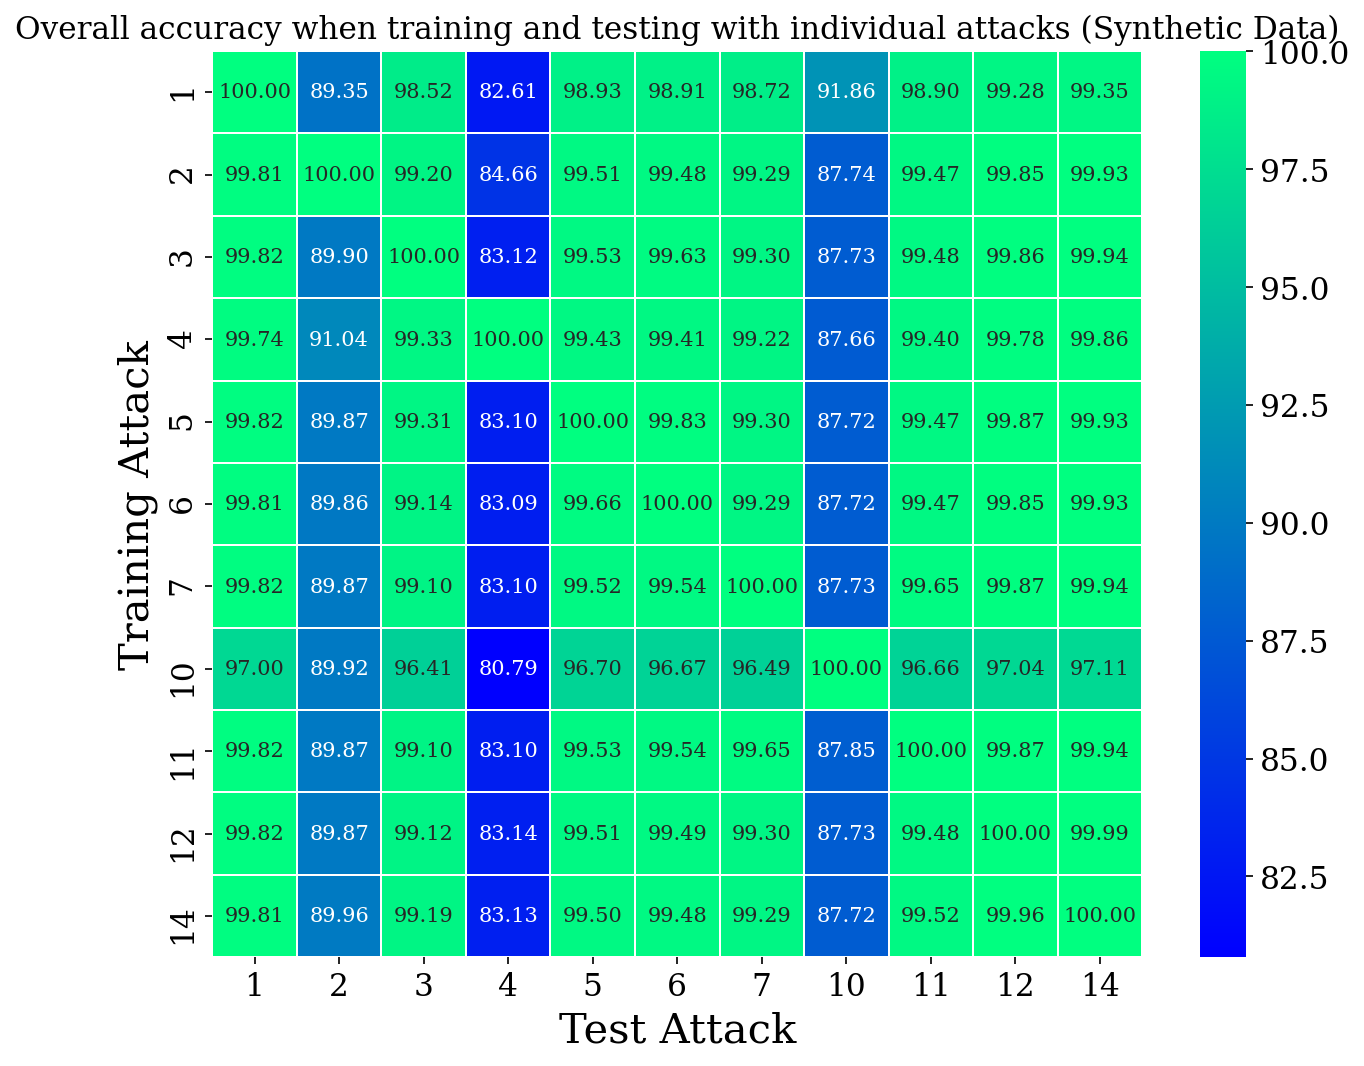

In [27]:
fig = plt.figure(figsize=(10, 8), dpi=150)

plt.rcParams["font.family"] = "serif"
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('axes', titlesize=15)  # fontsize of the figure title
# create some labels
attack_labels = [ "{0:d}".format(i) for i in attacks ]

# create a color map with random colors
#colmap = matplotlib.colors.ListedColormap(np.random.random((21,3)))
#colmap.colors[0] = [0,0,0]
import seaborn as sns
# this is the real plotting part
ax = fig.add_subplot(111)
sns.heatmap(accrd, linewidths=.5, annot=True, fmt='.2f', cmap='winter', ax=ax)


plt.xlabel('Test Attack')
plt.ylabel('Training Attack')
plt.title('Overall accuracy when training and testing with individual attacks (Synthetic Data)')

plt.show()

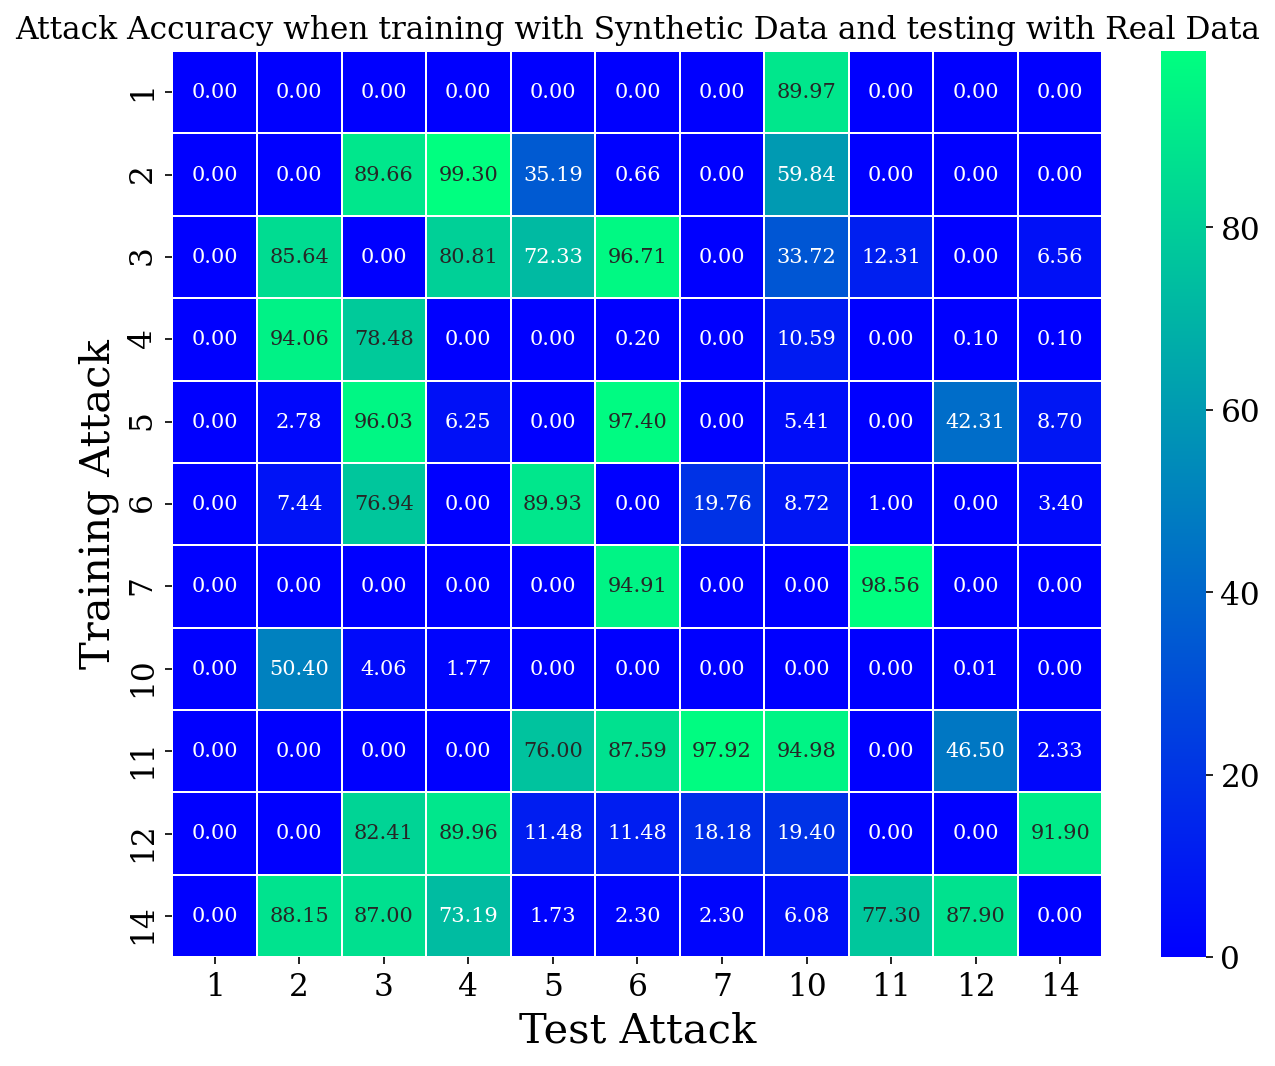

In [28]:
fig = plt.figure(figsize=(10, 8), dpi=150)

plt.rcParams["font.family"] = "serif"
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('axes', titlesize=15)  # fontsize of the figure title
# create some labels
attack_labels = [ "{0:d}".format(i) for i in attacks ]

# create a color map with random colors
#colmap = matplotlib.colors.ListedColormap(np.random.random((21,3)))
#colmap.colors[0] = [0,0,0]

# this is the real plotting part
ax = fig.add_subplot(111)
sns.heatmap(ataccrd, linewidths=.5, annot=True, fmt='.2f', cmap='winter', ax=ax)


plt.xlabel('Test Attack')
plt.ylabel('Training Attack')
plt.title('Attack Accuracy when training with Synthetic Data and testing with Real Data')
plt.show()